Знакомство с SCIKIT-TIME (SKTIME)

Знакомство с библиотекой машинного обучения для анализа временных рядов
sktime. Представления временных рядов с точки зрения задач машинного
обучения. Преобразования временных раядов. Предсказание временных рядов.

Imports

Scikit-Time (sktime) 
- это набор инструментов Python с открытым исходным кодом для
машинного обучения и работы с временными рядами. Это проект, реализуемый
сообществом и финансируемый Советом экономических и социальных исследований
Великобритании, Центром исследования потребительских данных и Институтом Алана
Тьюринга.

Sktime расширяет API scikit-learn для задач временных рядов. Он предоставляет
необходимые алгоритмы и инструменты преобразования для эффективного решения
задач регрессии, прогнозирования и классификации временных рядов. Библиотека
включает
специальные
алгоритмы
обучения
для
временных
рядов
и
методы
преобразования, не представленные во многих других распространенных библиотеках.

In [1]:
#!pip install sktime 
#!pip install pmdarima
#!pip install tbats

In [2]:
#!pip install sktime[all_extras]

In [3]:
import sktime
import pandas as pd
import numpy as np
from warnings import simplefilter
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
EnsembleForecaster,
MultiplexForecaster,
TransformedTargetForecaster,
make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate

In [6]:
from sktime.forecasting.model_selection import (
ExpandingWindowSplitter,
ForecastingGridSearchCV,
SlidingWindowSplitter,
temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.series.detrend import Deseasonalizer,Detrender
from sktime.utils.plotting import plot_series
simplefilter("ignore", FutureWarning)
%matplotlib inline

Набор данных

Для использования встроенных наборов данных мы можем импортировать их из
соответствующего модуля. Для начала импортируем уже знакомый вам набор данных с
пассажирами авиакомпаний.

In [9]:
import seaborn as sns
sns.set(rc={'font.size': 15})
sns.set(rc={'figure.figsize':(16, 4)})

output data type:  <class 'pandas.core.series.Series'>


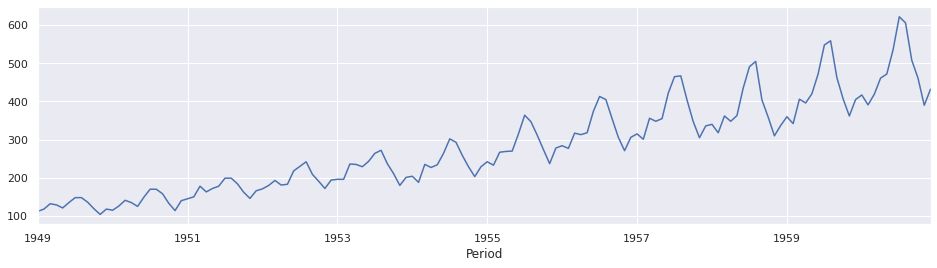

In [10]:
y = sktime.datasets.load_airline()
print('output data type: ',type(y))
y.plot();

In [18]:
y

1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [11]:
print(y.describe())

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: Number of airline passengers, dtype: float64


Мы также можем использовать встроенный метод plot_series для визуализации
данных.

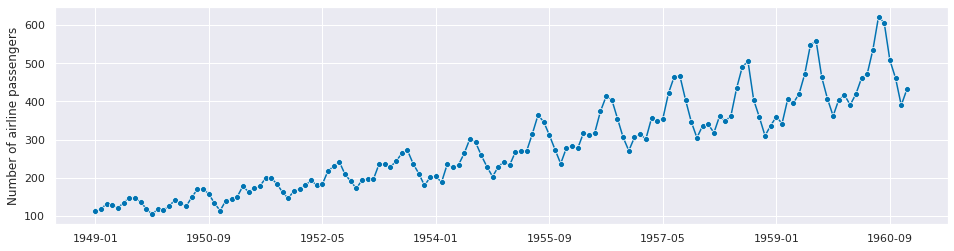

In [12]:
sktime.utils.plotting.plot_series(y);

Для разделения массивов или матриц на последовательные обучающие и тестовые
подмножества
мы
будем
использовать
метод
temporal_train_test_split.
Мы
будем
использовать
прогнозирование
с
заранее
определенным
горизонтом,
используя
переменную TEST_SIZE.

In [14]:
TEST_SIZE = 36
y_train, y_test =sktime.forecasting.model_selection.temporal_train_test_split(y,
test_size=TEST_SIZE)
print('check splitted data size: ', y_train.shape[0], y_test.shape[0])

check splitted data size:  108 36


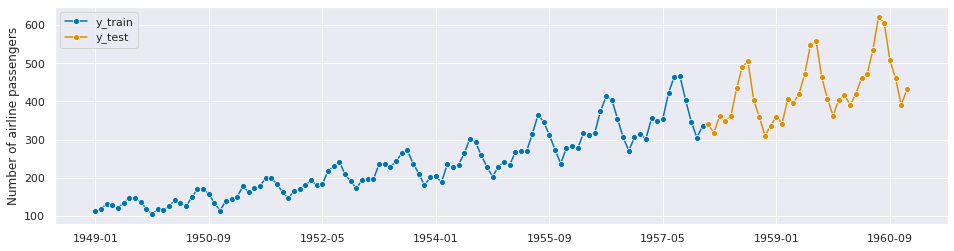

In [15]:
sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train",
"y_test"]);

После разделения мы можем указать горизонт прогнозирования, используя абсолютные
значениях отсчетов времени.

In [16]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
print(fh)

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)


В качестве альтернативы мы можем использовать относительные отсчеты,
испльзуя np.array

In [20]:
np.arange(len(y_test)) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [21]:
np.array([2, 5])

array([2, 5])

In [19]:
fh_ = np.arange(len(y_test)) + 1
fh_ = np.array([2, 5]) # 2nd and 5th step ahead

Задача предсказания
Традиционная постановка
Сделаем наивный прогноз, как на предыдущем занятии (по statsmodels.tsa). SKTime
позволяет сделать это в общем стиле, совместимом с другими scikit библиотеками. Для
оценки здесь будет использоваться так называемая мера Symmetry MAPE:

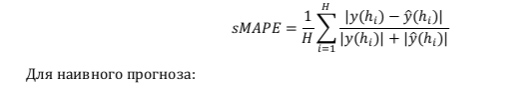

Для сезонного-наивного прогноза:

In [31]:
smape = MeanAbsolutePercentageError(symmetric=True)

score =  0.145427686270316


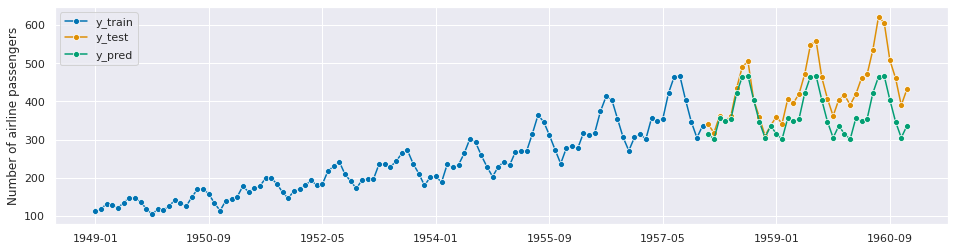

In [32]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))

Для Holt-Winter сглаживающего прогнзоа:

score =  0.05027662159649058


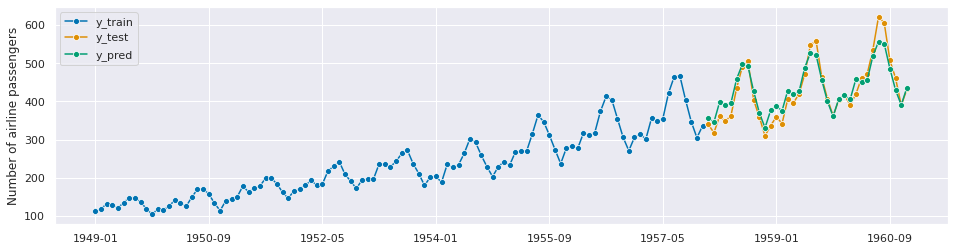

In [34]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test",
"y_pred"])
print('score = ',smape(y_pred, y_test))

Примечание для получения простого экспоненциального сглаживания (SES) и двойного
экспоненциального сглаживания (HOLT, DEA) используйте

In [35]:
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)

Для построения ансамбля методов используйте

score =  0.13930395710344726


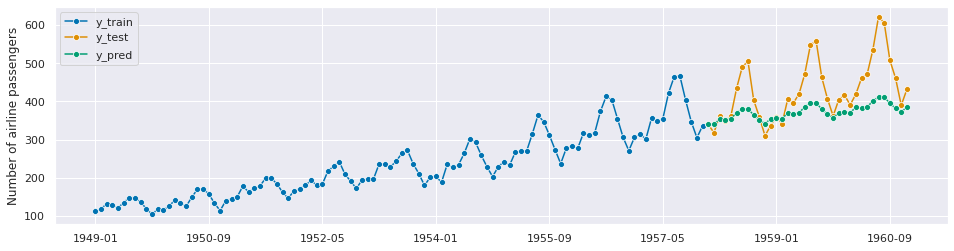

In [37]:
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive",sp=12)

forecaster = EnsembleForecaster([("ses", ses),
                                 ("holt", holt),
                                 ("damped", damped_holt),
                                 ("holt-winter",holt_winter)])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))


Для случая автоматизированного подбора гиперпараметров экспоненциального
сглаживания (Холта-Винтера):

score =  0.0631640040619606


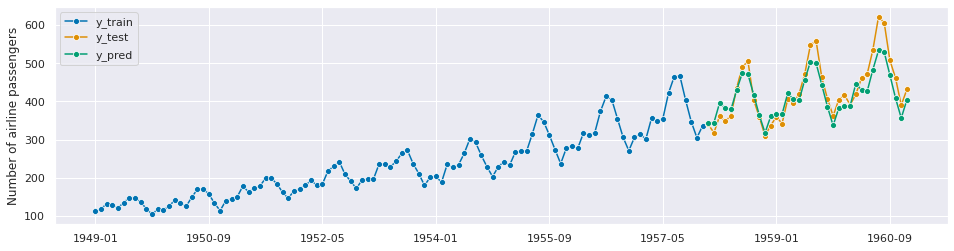

In [39]:
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))

Использование предсказаний с использованием библиотеки scikit-learn

Помимо встроенных методов, SKTime позволяет применять подходы, основанные на
scikit-learn. Например, задачу прогнозирования можно сравнить с задачей регрессии в
sklearn. Однако, прямое использование стандартной регрессии sklearn, требуют наличия
данных и меток, которые не нужны во временных рядах. Как будет показано ниже эта
проблема может быть сравнительно просто решена.

Лучший способ составить прогноз с использованием обычной регрессии - это
использовать
так
называемую
технику
“сокращения
прогнозирования”,
которая
представляет собой преобразование неявно имеющейся задачи долгосрочной регрессии
в задачу на основе скользящего окна. Такое преобразование можно сделать с помощью
метода make_reduction, как показано ниже.

Идея редукции состоит в том, чтобы свести задачу регрессии в отношении временных
рядов к проблеме табличной регрессии, как показано ниже. Обратите внимание, что в
задаче табличной регрессии или регрессии скользящего окна на этапе обучения вы
можете использовать предсказанные значения вместо известных в соответствующих
позициях. Это показано серыми стрелками.

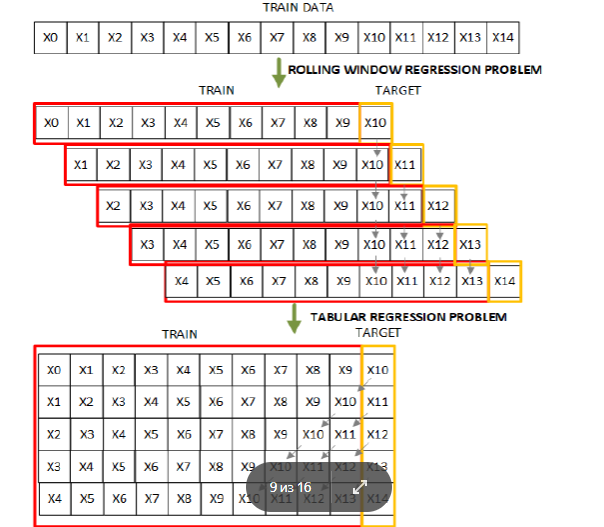

Посмотрим, как работает метод make_reduction. Существуют «прямые», «рекурсивные» и
«многовыводные» стратегии прогнозирования. В прямой стратегии мы используем
разные прогнозы для каждого результата (цели) (без серых стрелок). В рекурсивной
стратегии мы используем предыдущие результаты в прогнозах для каждого следующего
результата (с серыми стрелками). В стратегии с несколькими выходами мы напрямую
прогнозируем несколько шагов.

score =  0.23294908961087446


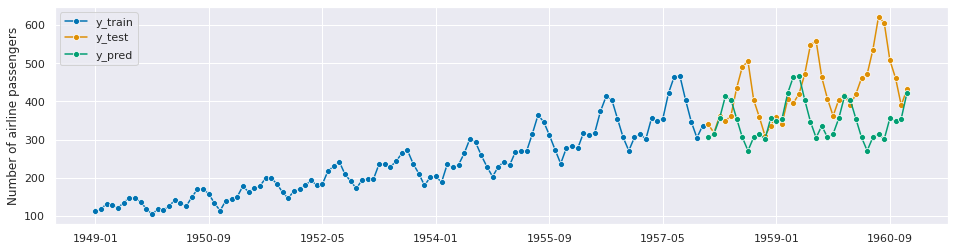

In [40]:
from sklearn.neighbors import KNeighborsRegressor
REGRESSION_WINDOW = 5
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW,
strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))

В make_reduction

 аргументы window_length и стратегии являются гиперпараметрами,
которые мы, можем оптимизировать. В приведенном ниже примере мы используем
поиск по сетке для проверки наилучшей длины окна. Для этого мы используется
следующие шаги:


создаем сетку длин окна


создание начального предсказателя с помощью регрессора KNeighborsRegressor.


Разделение выборки на тренировочную и для проверки (мы сделали это, сдвинув
начало окна до 80% размера выборки и продвинувшись с длиной 25 точек до
конца),


производим поиск по сетке прогнозов с оценкой на каждой итерации и функцией
SMAPE в качестве меры.

In [41]:
grid = {"window_length": [5, 7, 10, 12, 15,17,20]}
#initial forecaster
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor,
window_length=grid["window_length"][-1],strategy="recursive")
# use temporal cross-validation to find the optimal parameter.
cros_val = SlidingWindowSplitter( initial_window=int(len(y_train) * 0.7),
window_length=25)
#grid search
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cros_val,
param_grid=grid, scoring=MeanAbsolutePercentageError())
gscv.fit(y_train)
print('best window size = ',gscv.best_params_)
#to see the full protocol use the following code
pd.DataFrame(gscv.cv_results_)

best window size =  {'window_length': 12}


,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.130215,0.009703,0.008104,{'window_length': 5},7.0
1,0.116296,0.011264,0.008745,{'window_length': 7},6.0
2,0.094769,0.010802,0.009502,{'window_length': 10},2.0
3,0.090290,0.011842,0.008233,{'window_length': 12},1.0
4,0.094796,0.008185,0.007139,{'window_length': 15},4.0
5,0.094796,0.008800,0.032758,{'window_length': 17},4.0
6,0.094796,0.022160,0.073406,{'window_length': 20},4.0


после поиска вы можете сделать прогноз с наилучшими результатами

score =  0.14008272913734346


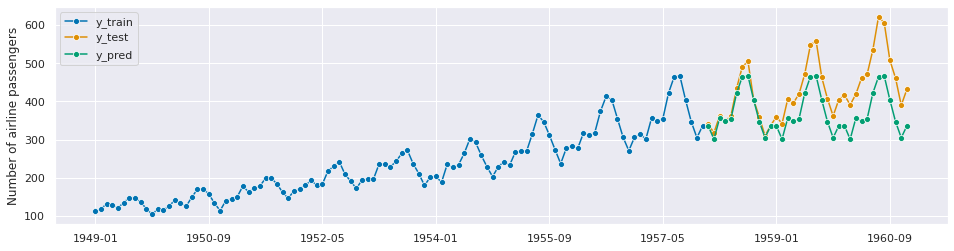

In [43]:
REGRESSION_WINDOW = 12
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW,
strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))

score =  0.14008272913734346


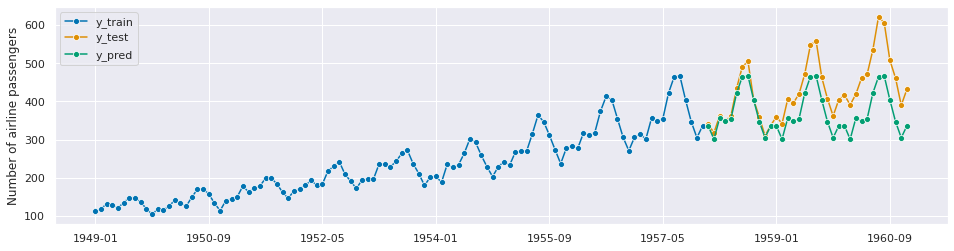

In [42]:
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))

Также возможен поиск по сетке другими методами.

{'selected_forecaster': 'holt_winter'} 


 MultiplexForecaster(forecasters=[('ses', ExponentialSmoothing(sp=12)),
                                 ('holt',
                                  ExponentialSmoothing(sp=12, trend='add')),
                                 ('holt_winter',
                                  ExponentialSmoothing(seasonal='additive',
                                                       sp=12, trend='add'))],
                    selected_forecaster='holt_winter')
score =  0.05027662159649058


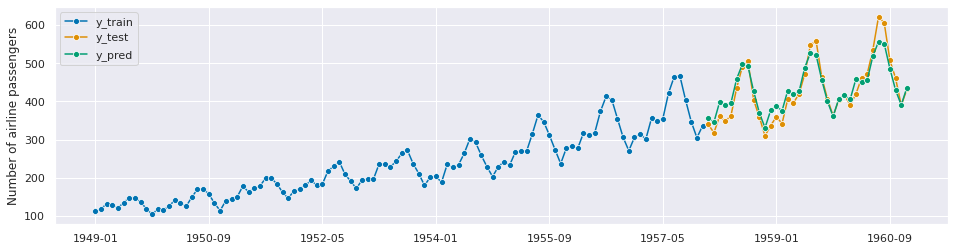

In [45]:
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive",
sp=12)
forecaster = MultiplexForecaster(
forecasters=[
("ses", ses),
("holt", holt),
("holt_winter", holt_winter),
]
)
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5),
window_length=30)
forecaster_grid = {"selected_forecaster": ["ses", "holt", "holt_winter"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv,
param_grid=forecaster_grid)
gscv.fit(y_train)
print(gscv.best_params_, "\n\n\n", gscv.best_forecaster_)
{'selected_forecaster': 'holt_winter'}
MultiplexForecaster(forecasters=[('ses', ExponentialSmoothing(sp=12)),
                                 ('holt',ExponentialSmoothing(sp=12,trend='add')),
                                 ('holt_winter',ExponentialSmoothing(seasonal='additive',sp=12,trend='add'))],
                    selected_forecaster='holt_winter')

y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test",
"y_pred"])
print('score = ',smape(y_pred, y_test))                             

Помимо простого деления train-test-split мы можем сделать ExpandingWindowSplitter.

In [46]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
forecaster = make_reduction(regressor,window_length=12,strategy="recursive")
cv = ExpandingWindowSplitter(step_length=12, 
                             fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             initial_window=72)
df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit",
return_data=True)
df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.126969,0.446294,0.238193,72,1954-12
1,0.059458,0.351866,0.227885,84,1955-12
2,0.074592,0.251634,0.171013,96,1956-12
3,0.136358,0.196994,0.101880,108,1957-12
4,0.065328,0.211218,0.114417,120,1958-12
5,0.054778,0.343639,0.230035,132,1959-12


теперь вы можете видеть результат этого ExpandingWindowSplitter.

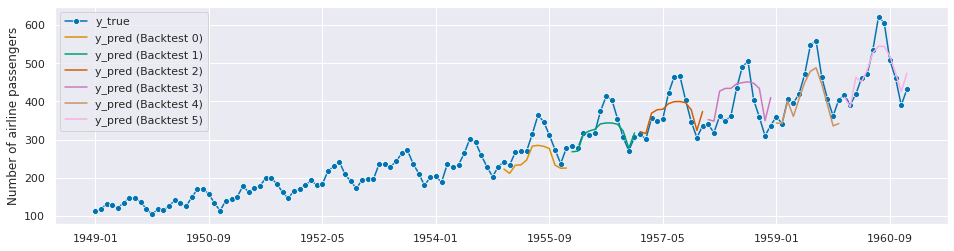

In [47]:
# visualization of a forecaster evaluation
fig, ax = plot_series(y,
                      df["y_pred"].iloc[0],
                      df["y_pred"].iloc[1],
                      df["y_pred"].iloc[2],
                      df["y_pred"].iloc[3],
                      df["y_pred"].iloc[4],
                      df["y_pred"].iloc[5],
                      markers=["o", "", "", "", "", "", ""],
                      labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)])
ax.legend();

Обратите внимание, что sktime содержит множество заимствований из других
пакетов. В некоторых случаях их необходимо будет установить дополнительно.

score =  0.04117062367046531


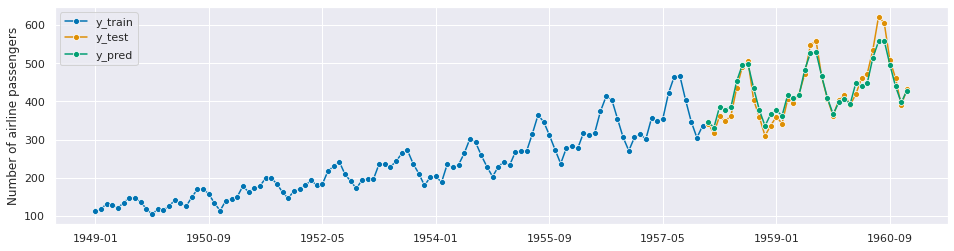

In [48]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))

score =  0.08493353477049953


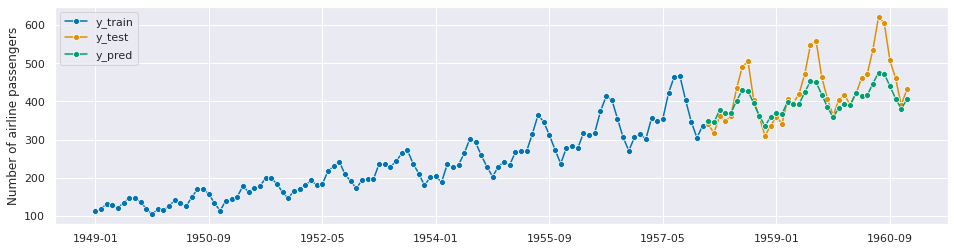

In [49]:
from sktime.forecasting.tbats import TBATS
forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))

Преобразование данных
Sktimes
содержит
ряд
инструментов
для
декомпозиции
временных
рядов
и
прогнозирования компонентов. Один из универсальных инструментов - преобразование
детрендинг.
Мы
можем
использовать
его
с
методом
прогнозирования
тренда
PolynomialTrendForecaster. В примере ниже мы будем использовать линейный тренд
(степень полинома равна 1).

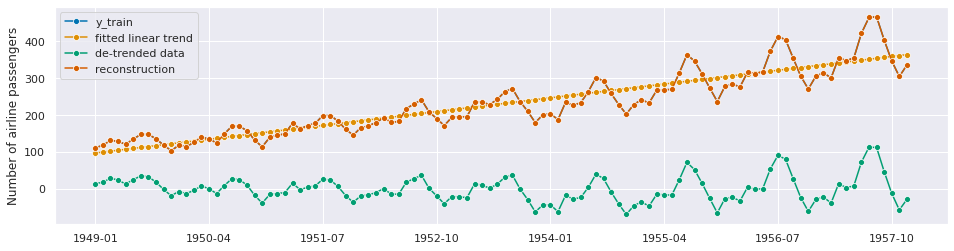

In [50]:
# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_detrend = transformer.fit_transform(y_train)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_trend = forecaster.fit(y_train).predict(fh=fh_ins)
reconstructed = y_trend + y_detrend
plot_series(y_train, y_trend, y_detrend, reconstructed,
            labels=["y_train", "fitted linear trend", "de-trended data","reconstruction"]);

Мы можем сделать конвейер трансформаций для прогноза, как это показано ниже.

score =  0.03983950097748028


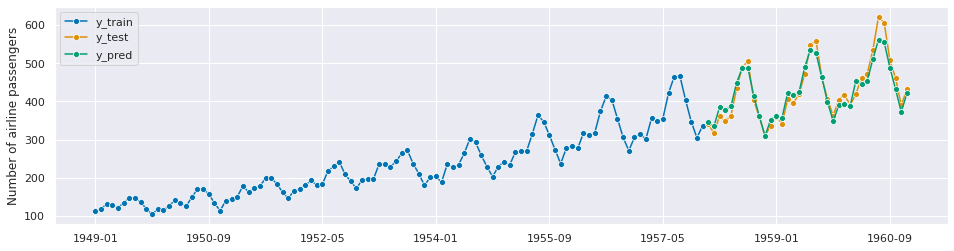

In [51]:
regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = TransformedTargetForecaster([("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
                                          ("detrend",Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
                                          ( "forecast",make_reduction(regressor,window_length=15,strategy="recursive"))])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test","y_pred"])
print('score = ',smape(y_pred, y_test))